## Evaluation with human judgements from SimpEval

In [1]:
# müssen noch ins Docker dingens
!pip install sacrebleu
!pip install evaluate
!pip install pandarallel

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from labeling_functions import get_all_lfs
import pandas as pd
import os
import tqdm
from scipy import stats
import pickle

from pandarallel import pandarallel
pandarallel.initialize()
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

from functools import lru_cache

from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

import warnings

/usr/local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


resources get initialised


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [11]:
# Metrics
from evaluate import load
sari = load("sari")

from usb_utils import bertscore
import textstat
fkgl = textstat.flesch_kincaid_grade

# BATS model
from bats_label_model import BatsModel
model = BatsModel("MTurkSF")
model_brit = BatsModel("britannica")
model_wiki = BatsModel("Wiki-Manual")
bats_score = model.calc_score

# MPIRE
from usb_utils import mpire_score

100%|██████████| 100/100 [00:00<00:00, 234.86epoch/s]
/workspace/pruning_lfs.py:52: RuntimeWarning: invalid value encountered in scalar divide
  merged_data.append([index, polarity, cov_simp, cov_src, precision, 1 - precision, cov_simp+cov_src, abs(cov_simp - cov_src), abs(cov_simp - cov_src)/(cov_simp+cov_src)])
/usr/local/lib/python3.8/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning: divide by zero encountered in divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)
100%|██████████| 100/100 [00:00<00:00, 295.10epoch/s]
/workspace/pruning_lfs.py:52: RuntimeWarning: invalid value encountered in scalar divide
  merged_data.append([index, polarity, cov_simp, cov_src, precision, 1 - precision, cov_simp+cov_src, abs(cov_simp - cov_src), abs(cov_simp - cov_src)/(cov_simp+cov_src)])
/usr/local/lib/python3.8/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning: divide by zero encountered in divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)


In [12]:
print(model.calc_naive_score("This is super simple, my dear friend!"))
print(model_brit.calc_naive_score("This is super simple, my dear friend!"))
print(model_wiki.calc_naive_score("This is super simple, my dear friend!"))

0.020453850971637277
0.016301654864873224
0.01795969194710185


In [13]:
print(model.calc_naive_score("To the suspensionable phthisis of exteriority, the suspense, which is killing the not-so-stupentious maturitiosity, does not interfere."))
print(model_brit.calc_naive_score("To the suspensionable phthisis of exteriority, the suspense, which is killing the not-so-stupentious maturitiosity, does not interfere."))
print(model_wiki.calc_naive_score("To the suspensionable phthisis of exteriority, the suspense, which is killing the not-so-stupentious maturitiosity, does not interfere."))


0.5002893847750938
0.5800817233528567
0.5796318908433191


In [14]:
# Datasets
df_simpeval_2022 = pd.read_csv("/workspace/datasets/simpeval/LENS/data/simpeval_2022.csv")
df_simpeval_DA = pd.read_csv("/workspace/datasets/simpeval/LENS/data/simpDA_2022.csv")
df_simpeval_likert = pd.read_csv("/workspace/datasets/simpeval/LENS/data/simplikert_2022.csv")

# preprocessed
from load_simplicity import load_asset_ds
from load_simplicity import load_metaeval_ds
from load_simplicity import load_questeval_ds
from load_simplicity import load_simpeval_ds

asset_simp = load_asset_ds()
metaeval_simp = load_metaeval_ds()
questeval_simp = load_questeval_ds()
simpeval_simp = load_simpeval_ds() # we need this one


In [15]:
asset_simp

,ds_id,src,simp,simplicityScore,meaningScore,origin
0,ASSET,"Since 2000, the recipient of the Kate Greenawa...","Since 2000, the winner of the Kate Greenaway m...",13.400000,42.266667,human
1,ASSET,"Following the drummers are dancers, who often ...","After the drummers are dancers, who often play...",43.200000,58.400000,human
2,ASSET,"However, the BzÃ¶ differs a bit in comparison ...","However, the BzÃ¶ is different from the freedo...",46.266667,59.933333,human
3,ASSET,"In its pure form, Dextromethorphan occurs as a...",", Dextromethorphan occurs.",19.800000,6.333333,human
4,ASSET,"Today NRC is organised as an independent, priv...",It is the largest country in the world.,43.666667,0.866667,human
...,...,...,...,...,...,...
95,ASSET,The sat reasoning test( formerly scholastic ap...,The sat reasoning test( formerly scholastic te...,17.933333,27.200000,human
96,ASSET,"After the Jerilderie raid, the gang laid low f...",", the gang laid low for 16 months evading capt...",67.266667,57.533333,human
97,ASSET,From 1900 to 1920 many new facilities were con...,"Facilities, were constructed, a chemistry buil...",7.800000,14.000000,human
98,ASSET,Pauline returned in the game boy remake of don...,It was released in the game boy remake of donk...,45.333333,12.000000,human


In [16]:
questeval_simp

,ds_id,src,simp,simplicityScore,meaningScore,origin
0,QuestEval,"Since 2000, the recipient of the Kate Greenawa...",Many people who receive the Kate Greenaway med...,83.357143,78.071429,human
1,QuestEval,"Since 2000, the recipient of the Kate Greenawa...","Since 2000, the winner of the Kate Greenaway m...",13.400000,42.266667,system
2,QuestEval,"Since 2000, the recipient of the Kate Greenawa...","Since 2000, the host of the Kate Greenaway med...",19.200000,36.300000,system
3,QuestEval,"Since 2000, the recipient of the Kate Greenawa...",Many people who receive the Kate Greenaway med...,75.533333,60.800000,human
4,QuestEval,"Following the drummers are dancers, who often ...",Drummers playing a Sogo (a tiny drum that make...,61.133333,48.866667,human
...,...,...,...,...,...,...
361,QuestEval,Pauline returned in the game boy remake of don...,It was released in the game boy remake of donk...,45.333333,12.000000,system
362,QuestEval,"There he had one daughter, later baptized as M...","There he had one daughter, baptized,.",40.714286,49.571429,system
363,QuestEval,"There he had one daughter, later baptized as M...","He had one daughter, who was baptized as Mary ...",63.133333,90.466667,human
364,QuestEval,"There he had one daughter, later baptized as M...","There he had one daughter, Mary Ann Fisher pow...",33.333333,17.733333,system


In [17]:
df_simpeval = simpeval_simp.loc[simpeval_simp.apply(lambda row: "simpDA_2022" in row["inner_ds"], axis=1)]

In [18]:
df_simpeval

,ds_id,src,simp,simplicityScore,meaningScore,origin,inner_ds
0,SimpEval_22,"On the fifth day of flight, November 20, 2022,...","On November 20, 2022, the Orion spacecraft sta...",93.555556,92.833333,GPT-3-few-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]"
1,SimpEval_22,The last president to run after leaving office...,The last president who ran after leaving the p...,86.888889,77.500000,Human 1 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]"
2,SimpEval_22,The complainant claimed that he had not renoun...,The complaint said he did not renounce his Nep...,87.777778,56.000000,Human 2 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]"
3,SimpEval_22,The club said on social media that customers s...,The club announced on social media that custom...,70.111111,85.500000,GPT-3-zero-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]"
4,SimpEval_22,Bone has published numerous books including Fa...,Bone has published many books including Fantas...,77.500000,85.166667,Muss,"[simpDA_2022, simplikert_2022]"
...,...,...,...,...,...,...,...
355,SimpEval_22,A Morning Consult poll in mid-November 2022 fo...,A Morning Consult poll in mid-November 2022 fo...,57.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"
356,SimpEval_22,Robinson returned to West Point in 1972 to ser...,Robinson returned to West Point in 1972 to be ...,60.222222,98.833333,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"
357,SimpEval_22,"In the interior, on the facade and the portico...","In the interior, on the facade and the portico...",62.888889,94.666667,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"
358,SimpEval_22,The Creative Gene is an autobiographical book ...,The Creative Gene is an autobiographical book ...,45.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"


In [19]:
df_simpeval_DA_dict = {}
for id in df_simpeval_DA["Input.id"].unique():
    df_simpeval_DA_dict[id] = {
    "Input.original": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id].iloc[0]["Input.original"],
    "Input.simplified": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id].iloc[0]["Input.simplified"],
    "Input.system": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id].iloc[0]["Input.system"],
    "Answer.adequacy": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id]["Answer.adequacy"].mean(),
    "Answer.fluency": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id]["Answer.fluency"].mean(),
    "Answer.simplicity": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id]["Answer.simplicity"].mean()
    }
df_simpeval_DA_mean = pd.DataFrame(df_simpeval_DA_dict).T

df_simpeval_likert_dict = {}
for id in df_simpeval_likert["Input.id"].unique():
    df_simpeval_likert_dict[id] = {
    "Input.original": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id].iloc[0]["Input.original"],
    "Input.simplified": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id].iloc[0]["Input.simplified"],
    "Input.system": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id].iloc[0]["Input.system"],
    "Answer.adequacy": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id]["Answer.adequacy"].mean(),
    "Answer.fluency": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id]["Answer.fluency"].mean(),
    "Answer.simplicity": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id]["Answer.simplicity"].mean()
    }
df_simpeval_likert_mean = pd.DataFrame(df_simpeval_likert_dict).T

In [20]:
df_simpeval = pd.read_pickle("df_simpeval_eval.pkl")

In [96]:
# BertScore

#df_simpeval["BERTscore"] = df_simpeval.progress_apply(lambda row: bertscore(row["src"], row["simp"]) , axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# Sari
#df_simpeval["sari"] = df_simpeval.progress_apply(lambda row:  sari.compute(sources=[row["src"]], predictions=[row["simp"]], references=[[]])["sari"] , axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# BATS score
#df_simpeval["test_MTurkSF_orig"] = df_simpeval.progress_apply(lambda row: bats_score(row["simp"]) , axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# FKGL
#df_simpeval["FKGL"] = df_simpeval.progress_apply(lambda row: fkgl(row["simp"]) , axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# BATS model
#df_simpeval["BATS"] = df_simpeval.progress_apply(lambda row: (-1*(model_wiki.calc_naive_score(row["simp"]))+1)*100, axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# BATS complex model
# df_simpeval["BATS_complex"] = df_simpeval.progress_apply(lambda row: (-1*(model_wiki.calc_naive_score(row["src"]))+1)*100, axis = 1)
# df_simpeval.to_pickle("df_simpeval_eval.pkl")

# BAT classification src
df_simpeval["BATS_label_src"] = df_simpeval.progress_apply(lambda row: (model_wiki.calc_score(row["src"])), axis = 1)
df_simpeval.to_pickle("df_simpeval_eval.pkl")

# BAT classification simp
df_simpeval["BATS_label_simp"] = df_simpeval.progress_apply(lambda row: (model_wiki.calc_score(row["simp"])), axis = 1)
df_simpeval.to_pickle("df_simpeval_eval.pkl")

100%|██████████| 360/360 [00:39<00:00,  9.04it/s]


In [50]:
pearson_r = {"simpeval_DA": 
{"BERTscore":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["BERTscore"].to_list()), 
"sari":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["sari"].to_list()), 
"BATSmodel_wiki":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["BATS"].to_list()), 
#"BATSscore":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["test_MTurkSF_orig"].to_list()), 
"fkgl":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["FKGL"].to_list())}
}

spearman_r = {"simpeval_DA": 
{"BERTscore":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["BERTscore"].to_list()), 
"sari":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["sari"].to_list()), 
"BATSmodel_wiki":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["BATS"].to_list()), 
#"BATSscore":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["test_MTurkSF_orig"].to_list()), 
"fkgl":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["FKGL"].to_list())}
}

In [51]:
pearson_r_meaning = {"simpeval_DA": 
{"BERTscore":stats.pearsonr(df_simpeval["meaningScore"].to_list(), df_simpeval["BERTscore"].to_list()), 
"sari":stats.pearsonr(df_simpeval["meaningScore"].to_list(), df_simpeval["sari"].to_list()), 
#"BATSscore":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["test_MTurkSF_orig"].to_list()), 
"fkgl":stats.pearsonr(df_simpeval["meaningScore"].to_list(), df_simpeval["FKGL"].to_list())}
}

In [52]:
pearson_r

{'simpeval_DA': {'BERTscore': PearsonRResult(statistic=-0.5714942551937424, pvalue=1.3349390777818822e-32),
  'sari': PearsonRResult(statistic=-0.2623660814414458, pvalue=4.4305464512684615e-07),
  'BATSmodel_wiki': PearsonRResult(statistic=0.43782284068900723, pvalue=2.7227948957042602e-18),
  'fkgl': PearsonRResult(statistic=-0.3900788382401816, pvalue=1.5671577258372067e-14)}}

In [53]:
pearson_r_meaning

{'simpeval_DA': {'BERTscore': PearsonRResult(statistic=0.4128879245280833, pvalue=2.975227225795268e-16),
  'sari': PearsonRResult(statistic=0.027976637360679745, pvalue=0.5967521255602046),
  'fkgl': PearsonRResult(statistic=0.051872148772101334, pvalue=0.32637440829663017)}}

In [100]:
df_simpeval

,ds_id,src,simp,simplicityScore,meaningScore,origin,inner_ds,BERTscore,sari,FKGL,BATS,BATS_complex,BATS_label,BATS_label_src,BATS_label_simp
0,SimpEval_22,"On the fifth day of flight, November 20, 2022,...","On November 20, 2022, the Orion spacecraft sta...",93.555556,92.833333,GPT-3-few-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.586026,66.666667,6.4,86.271465,18.867035,-1.0,1.0,0.0
1,SimpEval_22,The last president to run after leaving office...,The last president who ran after leaving the p...,86.888889,77.500000,Human 1 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.645294,66.666667,9.9,91.195466,18.856180,-1.0,1.0,0.0
2,SimpEval_22,The complainant claimed that he had not renoun...,The complaint said he did not renounce his Nep...,87.777778,56.000000,Human 2 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.614902,66.666667,10.3,90.847009,38.863279,-0.0,0.0,0.0
3,SimpEval_22,The club said on social media that customers s...,The club announced on social media that custom...,70.111111,85.500000,GPT-3-zero-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.726086,66.666667,10.5,80.317087,27.382656,-1.0,1.0,0.0
4,SimpEval_22,Bone has published numerous books including Fa...,Bone has published many books including Fantas...,77.500000,85.166667,Muss,"[simpDA_2022, simplikert_2022]",0.800024,66.666667,9.5,71.464361,23.671058,-1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,SimpEval_22,A Morning Consult poll in mid-November 2022 fo...,A Morning Consult poll in mid-November 2022 fo...,57.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.900024,75.000000,16.6,45.428257,16.324396,-1.0,1.0,0.0
356,SimpEval_22,Robinson returned to West Point in 1972 to ser...,Robinson returned to West Point in 1972 to be ...,60.222222,98.833333,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.907937,66.666667,7.6,91.482194,60.760556,-0.0,0.0,0.0
357,SimpEval_22,"In the interior, on the facade and the portico...","In the interior, on the facade and the portico...",62.888889,94.666667,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.890400,66.666667,11.3,75.764799,21.552275,-1.0,1.0,0.0
358,SimpEval_22,The Creative Gene is an autobiographical book ...,The Creative Gene is an autobiographical book ...,45.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.970796,66.666667,20.5,24.073468,24.675356,-1.0,1.0,1.0


In [89]:
pos = 0
neg = 0
for i, row in df_simpeval.iterrows():
    if row["BATS"] > row["BATS_complex"]:
        pos += 1
    else:
        neg += 1

print(pos,neg)

342 18


In [ ]:
pos = 0
neg = 0
for i, row in df_simpeval.iterrows():
    if row["BATS_label_simp"] > row["BATS_complex"]:
        pos += 1
    else:
        neg += 1

print(pos,neg)

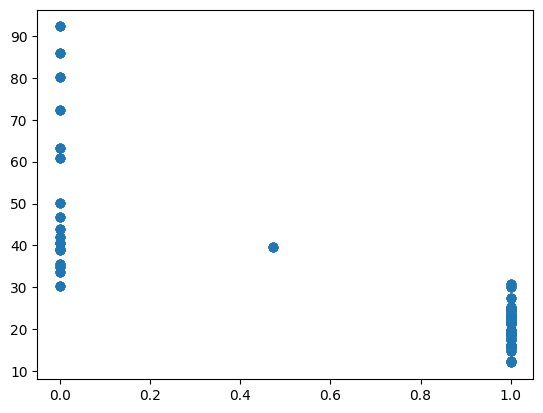

In [101]:
x = np.array(df_simpeval["BATS_label_src"].to_list())
y = np.array(df_simpeval["BATS_complex"].to_list())

plt.scatter(x, y)
plt.show()

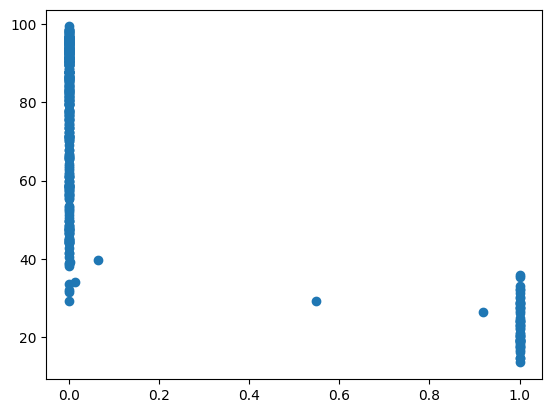

In [98]:
x = np.array(df_simpeval["BATS_label_simp"].to_list())
y = np.array(df_simpeval["BATS"].to_list())

plt.scatter(x, y)
plt.show()

In [ ]:
x = np.array(df_simpeval["BERTscore"].to_list())
y = np.array(df_simpeval["simplicityScore"].to_list())

plt.scatter(x, y)
plt.show()

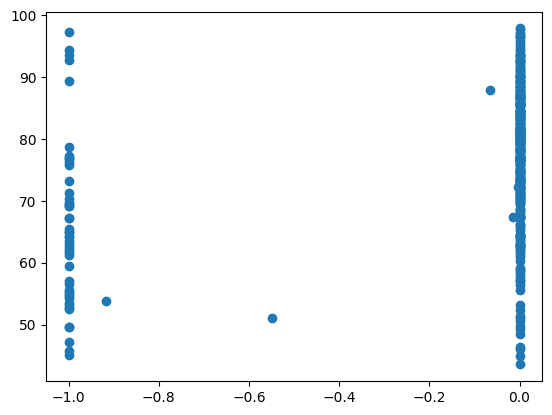

In [95]:
x = np.array(df_simpeval["BATS_label_simp"].to_list())
y = np.array(df_simpeval["simplicityScore"].to_list())

plt.scatter(x, y)
plt.show()

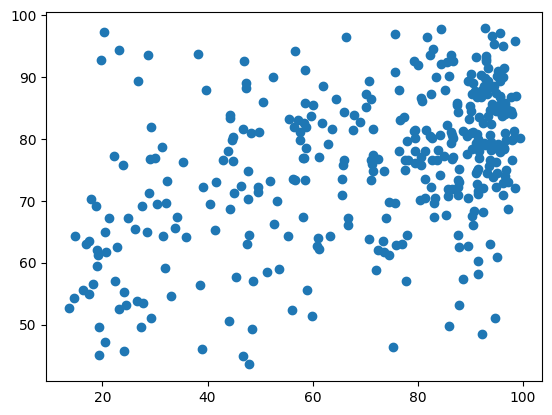

In [56]:
x = np.array(df_simpeval["BATS"].to_list())
y = np.array(df_simpeval["simplicityScore"].to_list())

plt.scatter(x, y)
plt.show()

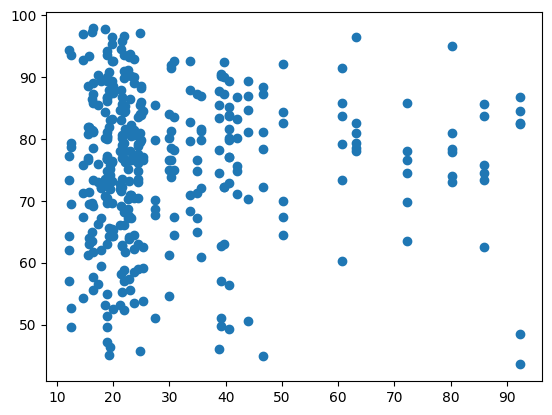

In [85]:
x = np.array(df_simpeval["BATS_complex"].to_list())
y = np.array(df_simpeval["simplicityScore"].to_list())

plt.scatter(x, y)
plt.show()

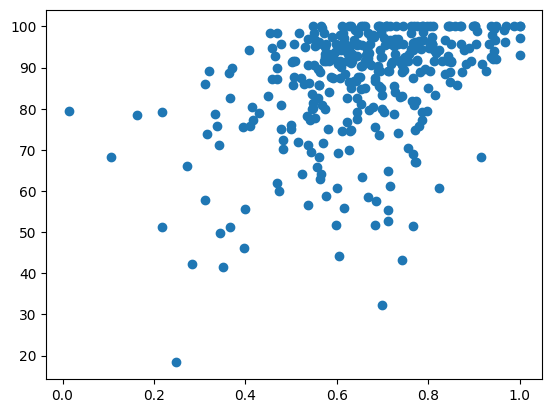

In [57]:
x = np.array(df_simpeval["BERTscore"].to_list())
y = np.array(df_simpeval["meaningScore"].to_list())

plt.scatter(x, y)
plt.show()

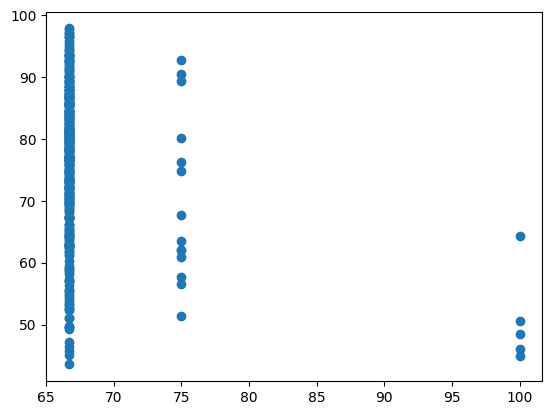

In [86]:
x = np.array(df_simpeval["sari"].to_list())
y = np.array(df_simpeval["simplicityScore"].to_list())

plt.scatter(x, y)
plt.show()

In [59]:
spearman_r

{'simpeval_DA': {'BERTscore': SignificanceResult(statistic=-0.5551451744922765, pvalue=1.7206631387694662e-30),
  'sari': SignificanceResult(statistic=-0.17527113383053647, pvalue=0.0008382055436318228),
  'BATSmodel_wiki': SignificanceResult(statistic=0.40194373871284866, pvalue=2.0705194153636843e-15),
  'fkgl': SignificanceResult(statistic=-0.322158175500493, pvalue=3.8768147375506035e-10)}}

## Checking weights for LF Clusters

In [60]:
from pruning_lfs import prune_lfs as pruner

In [61]:
lfs = pruner()

/workspace/pruning_lfs.py:52: RuntimeWarning: invalid value encountered in scalar divide
  merged_data.append([index, polarity, cov_simp, cov_src, precision, 1 - precision, cov_simp+cov_src, abs(cov_simp - cov_src), abs(cov_simp - cov_src)/(cov_simp+cov_src)])


In [128]:
cluster_manual = pickle.load(open("/workspace/datasets/clustering_manual_LFs.pkl", "rb"))
cluster_automatic = pickle.load(open("/workspace/datasets/auto_cluster_dic.pkl", "rb"))

auto = []
manual = []

for k in cluster_manual.keys():
    auto.append(cluster_automatic[k])
    manual.append(cluster_manual[k])
    print(k,auto[-1], manual[-1])


lf_words_cnt_wcount=15_SIMPLE 0 0
lf_words_cnt_wcount=16_SIMPLE 0 0
lf_words_cnt_wcount=17_SIMPLE 0 0
lf_words_cnt_wcount=18_SIMPLE 0 0
lf_words_cnt_wcount=19_SIMPLE 2 0
lf_words_cnt_wcount=20_SIMPLE 2 0
lf_words_cnt_wcount=21_SIMPLE 2 0
lf_words_cnt_wcount=22_SIMPLE 2 0
lf_words_cnt_wcount=23_SIMPLE 2 0
lf_words_cnt_wcount=24_SIMPLE 2 0
lf_words_cnt_wcount=20_NOT_SIMPLE 1 0
lf_words_cnt_wcount=21_NOT_SIMPLE 1 0
lf_words_cnt_wcount=22_NOT_SIMPLE 1 0
lf_words_cnt_wcount=23_NOT_SIMPLE 1 0
lf_words_cnt_wcount=24_NOT_SIMPLE 1 0
lf_words_cnt_wcount=25_NOT_SIMPLE 1 0
lf_words_cnt_wcount=26_NOT_SIMPLE 1 0
lf_words_cnt_wcount=27_NOT_SIMPLE 1 0
lf_words_cnt_wcount=28_NOT_SIMPLE 1 0
lf_words_cnt_wcount=29_NOT_SIMPLE 0 0
lf_words_cnt_wcount=30_NOT_SIMPLE 0 0
lf_words_cnt_wcount=31_NOT_SIMPLE 0 0
lf_words_cnt_wcount=32_NOT_SIMPLE 0 0
lf_words_cnt_wcount=33_NOT_SIMPLE 0 0
lf_words_cnt_wcount=34_NOT_SIMPLE 0 0
lf_words_cnt_wcount=35_NOT_SIMPLE 0 0
lf_words_cnt_wcount=36_NOT_SIMPLE 0 0
lf_words_cnt_w

In [103]:
lf_names = [a.name for a in lfs]

In [122]:
model_lf_weights_brit = {}
for i, weight in enumerate(model_brit.label_model.get_weights()):
    model_lf_weights_brit[lf_names[i]] = weight

/usr/local/lib/python3.8/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning: divide by zero encountered in divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)


In [106]:
model_lf_weights_wiki = {}
for i, weight in enumerate(model_wiki.label_model.get_weights()):
    model_lf_weights_wiki[lf_names[i]] = weight

In [110]:
model_lf_weights = {}
for i, weight in enumerate(model.label_model.get_weights()):
    model_lf_weights[lf_names[i]] = weight

In [126]:
cluster_weights = {}
for v in set(cluster_manual.values()):
    cluster_weights[v] = []

for k in cluster_manual.keys():
    cluster_weights[cluster_manual[k]].append(model_lf_weights[k])

# wiki 
cluster_weights_wiki = {}
for v in set(cluster_manual.values()):
    cluster_weights_wiki[v] = []

for k in cluster_manual.keys():
    cluster_weights_wiki[cluster_manual[k]].append(model_lf_weights_wiki[k])


In [72]:
for k in cluster_weights.keys():
    print(k, np.sum(cluster_weights[k]))

Lexical 108.92948228127669
Pragmatic 2.8890252453093925
Structural 122.37321378481032
Syntactic 37.22355829608548


In [127]:
for k in cluster_weights_wiki.keys():
    print(k, np.sum(cluster_weights_wiki[k]))^

Lexical 105.81725250917661
Pragmatic 2.9653020593276778
Structural 117.27135212876047
Syntactic 40.633266768003224
